Assignment 3 : Classification Finale
===
##Hector Curi - Spencer Kaiser

---
Instructions
---
You are to build upon the predictive analysis (classification) that you already completed in assignment two, adding additional modeling from new classification algorithms. You should use appropriate cross validation for all of your analysis (you should exlpain your chosen method of validation). Try to use as much testing data as possible in a realistic manner (you should define what you think is realistic and why). Follow the CRISP-DM framework in your analysis (you are not performing all of the CRISP-DM outline, only the portions relevant to the grading rubric outlined below). This report is worth 20% of the final grade. You may complete this assignment in teams of as many as three people (but no more). Only turn in one report to blackboard. 

Write a report covering all the steps of the project. The results should be reproducible using your report. Please carefully describe every assumption and every step in your report.

---
Dataset Selection
---
Select a dataset identically to the way you selected for assignment one. You are not required to use the same dataset that you used for assignment one, but you are encouraged. You must identify two or more classification tasks from the dataset. For example, if your dataset was from the diabetes data you might try to predict two tasks: (1) if a patient will be readmitted within a 30 day period or not, and (2) what the total number of days a patient will spend in the hospital, given their history and specifics of the encounter. 

---
### Choice of Classification Tasks
We want to predict the following:
1. Predict if a person makes more than $50,000 dollars a year, based on their age, race, sex, etc. (all of the attributes)
2. Predict if a person makes capital trades, based on their age, race, sex, etc. (all of the attributes)
3. Predict if a person is male, based on their workclass, occupation, age, etc. (all of the attributes)
---
### Initial Code


In [2]:
#import all packages used in this assignment
import pandas as pd
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from pandas.tools.plotting import scatter_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from numpy import random as rd
from sklearn import metrics as mt
warnings.simplefilter('ignore', DeprecationWarning)
%matplotlib inline

# read in the csv file
df_raw = pd.read_csv('data/adult.data')

Data Preparation
---

---
### 1. Class Variables (20 points)
**Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). And use pre-processing methods as needed for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis**

In [3]:
# Here is the general description of our data
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32561 entries, 0 to 32560
Data columns (total 15 columns):
age               32561 non-null int64
workclass         32561 non-null object
fnlwgt            32561 non-null int64
education         32561 non-null object
education-num     32561 non-null int64
marital-status    32561 non-null object
occupation        32561 non-null object
relationship      32561 non-null object
race              32561 non-null object
sex               32561 non-null object
capital-gain      32561 non-null int64
capital-loss      32561 non-null int64
hours-per-week    32561 non-null int64
native-country    32561 non-null object
income            32561 non-null object
dtypes: int64(6), object(9)
memory usage: 4.0+ MB


In [4]:
# As we can see, it seems that all of the values are there, but after looking at the actual data file
# we noticed that there are some values recorded as '?', these are the missing values.

# First let's replace ' ?' with NaN (not a number) for all the missing values
df = df_raw.replace(to_replace='?',value=np.nan)

# Now let's see how many values we actually have
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32561 entries, 0 to 32560
Data columns (total 15 columns):
age               32561 non-null int64
workclass         30725 non-null object
fnlwgt            32561 non-null int64
education         32561 non-null object
education-num     32561 non-null int64
marital-status    32561 non-null object
occupation        30718 non-null object
relationship      32561 non-null object
race              32561 non-null object
sex               32561 non-null object
capital-gain      32561 non-null int64
capital-loss      32561 non-null int64
hours-per-week    32561 non-null int64
native-country    31978 non-null object
income            32561 non-null object
dtypes: int64(6), object(9)
memory usage: 4.0+ MB


In [5]:
# We can see that workclass, occupation and native-country have some missing values.
# Because only 2399 rows have missing values in them out of 32561 total (7.36% of the data),
# We will just remove those instances from our dataset.

df = df.dropna(how='any')

# Now the data has 30162 instances with no missing values. :)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30162 entries, 0 to 32560
Data columns (total 15 columns):
age               30162 non-null int64
workclass         30162 non-null object
fnlwgt            30162 non-null int64
education         30162 non-null object
education-num     30162 non-null int64
marital-status    30162 non-null object
occupation        30162 non-null object
relationship      30162 non-null object
race              30162 non-null object
sex               30162 non-null object
capital-gain      30162 non-null int64
capital-loss      30162 non-null int64
hours-per-week    30162 non-null int64
native-country    30162 non-null object
income            30162 non-null object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [6]:
# Now we are going to remove the attributes that we think are not useful for our model
# fnlwgt is an assigned weight by the census bureau, we don't know it's formula so its useless to us
del df['fnlwgt']

# education-num is an ordinal representation of the education level, which is better for data modelling
# thus we remove the education attribute
del df['education']

# relationship contains very strange values such as "Not-in-family, Other-relative, Own-child", so we will get rid of it.
del df['relationship']

In [7]:
# Now our data contains these attributes
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30162 entries, 0 to 32560
Data columns (total 12 columns):
age               30162 non-null int64
workclass         30162 non-null object
education-num     30162 non-null int64
marital-status    30162 non-null object
occupation        30162 non-null object
race              30162 non-null object
sex               30162 non-null object
capital-gain      30162 non-null int64
capital-loss      30162 non-null int64
hours-per-week    30162 non-null int64
native-country    30162 non-null object
income            30162 non-null object
dtypes: int64(5), object(7)
memory usage: 3.0+ MB


In [8]:
# Now we are going to rename the attributes for an easier understanding of the data
df = df.rename(columns={'income': 'salaryOver50K', 'sex': 'isMale', 'education-num':'educationLevel',
                        'marital-status':'maritalStatus','capital-gain':'capitalGain','capital-loss':'capitalLoss',
                        'native-country':'nativeCountry','hours-per-week':'hoursPerWeek'})

In [9]:
# Now our data contains these attributes
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30162 entries, 0 to 32560
Data columns (total 12 columns):
age               30162 non-null int64
workclass         30162 non-null object
educationLevel    30162 non-null int64
maritalStatus     30162 non-null object
occupation        30162 non-null object
race              30162 non-null object
isMale            30162 non-null object
capitalGain       30162 non-null int64
capitalLoss       30162 non-null int64
hoursPerWeek      30162 non-null int64
nativeCountry     30162 non-null object
salaryOver50K     30162 non-null object
dtypes: int64(5), object(7)
memory usage: 3.0+ MB


In [10]:
# Now let's convert to camel case all of the values with dashes in workclass
df = df.replace(to_replace='Federal-gov',value='FederalGovernment')
df = df.replace(to_replace='State-gov',value='StateGovernment')
df = df.replace(to_replace='Never-worked',value='NeverWorked')
df = df.replace(to_replace='Private',value='Private')
df = df.replace(to_replace='Self-emp-inc',value='SelfEmployedIncorporated')
df = df.replace(to_replace='Self-emp-not-inc',value='SelfEmpoyedNotIncorporated')
df = df.replace(to_replace='Local-gov',value='LocalGovernment')
df = df.replace(to_replace='Without-pay',value='WithoutPay')

# Now let's convert to camel case all of the values with dashes in marital status
df = df.replace(to_replace='Married-AF-spouse',value='MarriedAFSpouse')
df = df.replace(to_replace='Married-civ-spouse',value='MarriedCivSpouse')
df = df.replace(to_replace='Married-spouse-absent',value='MarriedSpouseAbsent')
df = df.replace(to_replace='Never-married',value='NeverMarried')

# Now let's convert to camel case all of the values with dashes in occupation
df = df.replace(to_replace='Adm-clerical',value='AdmClerical')
df = df.replace(to_replace='Armed-Forces,',value='ArmedForces,')
df = df.replace(to_replace='Craft-repair',value='CraftRepair')
df = df.replace(to_replace='Exec-managerial',value='ExecManagerial')
df = df.replace(to_replace='Farming-fishing',value='FarmingFishing')
df = df.replace(to_replace='Handlers-cleaners',value='HandlersCleaners')
df = df.replace(to_replace='Machine-op-inspct',value='MachineOpsInspector')
df = df.replace(to_replace='Other-service',value='OtherService')
df = df.replace(to_replace='Priv-house-serv',value='PrivHouseServ')
df = df.replace(to_replace='Prof-specialty',value='ProfSpecialty')
df = df.replace(to_replace='Protective-serv',value='ProtectiveServant')
df = df.replace(to_replace='Tech-support',value='TechSupport')
df = df.replace(to_replace='Transport-moving',value='TransportMoving')

# Now let's convert to camel case all of the values with dashes in race
df = df.replace(to_replace='Amer-Indian-Eskimo',value='AmerIndianEskimo')
df = df.replace(to_replace='Asian-Pac-Islander',value='AsianPacIslander')

# Now let's convert to camel case all of the values with dashes in nativeCountry
df = df.replace(to_replace='Dominican-Republic',value='DominicanRepublic,')
df = df.replace(to_replace='El-Salvador',value='ElSalvador,')
df = df.replace(to_replace='Holand-Netherlands',value='Netherlands')
df = df.replace(to_replace='Outlying-US(Guam-USVI-etc)',value='OutlyingUS')
df = df.replace(to_replace='Puerto-Rico',value='PuertoRico')
df = df.replace(to_replace='Trinadad&Tobago',value='Trinidad&Tobago')
df = df.replace(to_replace='United-States',value='US')

In [11]:
# Now our data looks like this
df.head()

,age,workclass,educationLevel,maritalStatus,occupation,race,isMale,capitalGain,capitalLoss,hoursPerWeek,nativeCountry,salaryOver50K
0,39,StateGovernment,13,NeverMarried,AdmClerical,White,Male,2174,0,40,US,<=50K
1,50,SelfEmpoyedNotIncorporated,13,MarriedCivSpouse,ExecManagerial,White,Male,0,0,13,US,<=50K
2,38,Private,9,Divorced,HandlersCleaners,White,Male,0,0,40,US,<=50K
3,53,Private,7,MarriedCivSpouse,HandlersCleaners,Black,Male,0,0,40,US,<=50K
4,28,Private,13,MarriedCivSpouse,ProfSpecialty,Black,Female,0,0,40,Cuba,<=50K


In [12]:
# Now let's replace the binomial attributes with binary values 1 and 0
# replace sex values with binary values
df = df.replace(to_replace='Female',value=0)
df = df.replace(to_replace='Male',value=1)

# replace income values with binary values
df = df.replace(to_replace='<=50K',value=0)
df = df.replace(to_replace='>50K',value=1)

In [13]:
# Now our data looks like this
df.head()

,age,workclass,educationLevel,maritalStatus,occupation,race,isMale,capitalGain,capitalLoss,hoursPerWeek,nativeCountry,salaryOver50K
0,39,StateGovernment,13,NeverMarried,AdmClerical,White,1,2174,0,40,US,0
1,50,SelfEmpoyedNotIncorporated,13,MarriedCivSpouse,ExecManagerial,White,1,0,0,13,US,0
2,38,Private,9,Divorced,HandlersCleaners,White,1,0,0,40,US,0
3,53,Private,7,MarriedCivSpouse,HandlersCleaners,Black,1,0,0,40,US,0
4,28,Private,13,MarriedCivSpouse,ProfSpecialty,Black,0,0,0,40,Cuba,0


In [14]:
# Now let's rearrange the columns
df = df[['isMale','age','race','nativeCountry','maritalStatus',
         'educationLevel','workclass','occupation','hoursPerWeek',
         'capitalGain','capitalLoss','salaryOver50K']]
df.head()

,isMale,age,race,nativeCountry,maritalStatus,educationLevel,workclass,occupation,hoursPerWeek,capitalGain,capitalLoss,salaryOver50K
0,1,39,White,US,NeverMarried,13,StateGovernment,AdmClerical,40,2174,0,0
1,1,50,White,US,MarriedCivSpouse,13,SelfEmpoyedNotIncorporated,ExecManagerial,13,0,0,0
2,1,38,White,US,Divorced,9,Private,HandlersCleaners,40,0,0,0
3,1,53,Black,US,MarriedCivSpouse,7,Private,HandlersCleaners,40,0,0,0
4,0,28,Black,Cuba,MarriedCivSpouse,13,Private,ProfSpecialty,40,0,0,0


In [15]:
# We can also group by age range like this
df['ageRange'] = pd.cut(df.age,[16,20,30,40,50,60,70,80,91],8,
                         labels=['17-20','20s','30s','40s','50s','60s','70s','80s',])

In [16]:
# And by hours-per-week
df['hourRange'] = pd.cut(df['hoursPerWeek'], [0,21,41,61,81,100], 5, labels=['1-20', '21-40', '41-60','61-80','80-99'])

In [17]:
# For capital gain and capital loss, based on the fact that someone with a capital gain
# can't have a capital loss, and viceversa, we will combine the attributes into one
# then we will store as a boolean of wheter they make capital transactions or not
# most people in the dataset have a value of 0 in both, so it is more useful to know 
# wheter they invest in capital or not, as opposed to how much they do it
df['hasCapitalTransactions'] = ((df.capitalGain - df.capitalLoss)!=0).astype(np.int)

In [18]:
df.head()

,isMale,age,race,nativeCountry,maritalStatus,educationLevel,workclass,occupation,hoursPerWeek,capitalGain,capitalLoss,salaryOver50K,ageRange,hourRange,hasCapitalTransactions
0,1,39,White,US,NeverMarried,13,StateGovernment,AdmClerical,40,2174,0,0,30s,21-40,1
1,1,50,White,US,MarriedCivSpouse,13,SelfEmpoyedNotIncorporated,ExecManagerial,13,0,0,0,40s,1-20,0
2,1,38,White,US,Divorced,9,Private,HandlersCleaners,40,0,0,0,30s,21-40,0
3,1,53,Black,US,MarriedCivSpouse,7,Private,HandlersCleaners,40,0,0,0,50s,21-40,0
4,0,28,Black,Cuba,MarriedCivSpouse,13,Private,ProfSpecialty,40,0,0,0,20s,21-40,0


In [19]:
# Also here are the data types of our attributes, as we can see isMale and salaryOver50K are already integers
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30162 entries, 0 to 32560
Data columns (total 15 columns):
isMale                    30162 non-null int64
age                       30162 non-null int64
race                      30162 non-null object
nativeCountry             30162 non-null object
maritalStatus             30162 non-null object
educationLevel            30162 non-null int64
workclass                 30162 non-null object
occupation                30162 non-null object
hoursPerWeek              30162 non-null int64
capitalGain               30162 non-null int64
capitalLoss               30162 non-null int64
salaryOver50K             30162 non-null int64
ageRange                  30162 non-null category
hourRange                 30162 non-null category
hasCapitalTransactions    30162 non-null int64
dtypes: category(2), int64(8), object(5)
memory usage: 3.3+ MB


In [20]:
# Now we will make all the categorical (object) attributes into one-hot encoded values
# Also store current dataframe just in case
dfClean = df.copy(deep=True)

# race
tmp_df = pd.get_dummies(df.race,prefix='race')
dfModel = pd.concat((df,tmp_df),axis=1)

# nativeCountry
tmp_df = pd.get_dummies(df.nativeCountry,prefix='origin')
dfModel = pd.concat((dfModel,tmp_df),axis=1)

# maritalStatus
tmp_df = pd.get_dummies(df.maritalStatus,prefix='marriage')
dfModel = pd.concat((dfModel,tmp_df),axis=1)

# workclass
tmp_df = pd.get_dummies(df.workclass,prefix='workclass')
dfModel = pd.concat((dfModel,tmp_df),axis=1)

# occupation
tmp_df = pd.get_dummies(df.occupation,prefix='occupation')
dfModel = pd.concat((dfModel,tmp_df),axis=1)

# occupation
tmp_df = pd.get_dummies(df.ageRange,prefix='ageRange')
dfModel = pd.concat((dfModel,tmp_df),axis=1)

# occupation
tmp_df = pd.get_dummies(df.hourRange,prefix='hourRange')
dfModel = pd.concat((dfModel,tmp_df),axis=1)

# print data model
df = dfModel
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30162 entries, 0 to 32560
Columns: 102 entries, isMale to hourRange_80-99
dtypes: category(2), float64(87), int64(8), object(5)
memory usage: 23.3+ MB


In [21]:
df.head()

,isMale,age,race,nativeCountry,maritalStatus,educationLevel,workclass,occupation,hoursPerWeek,capitalGain,...,ageRange_40s,ageRange_50s,ageRange_60s,ageRange_70s,ageRange_80s,hourRange_1-20,hourRange_21-40,hourRange_41-60,hourRange_61-80,hourRange_80-99
0,1,39,White,US,NeverMarried,13,StateGovernment,AdmClerical,40,2174,...,0,0,0,0,0,0,1,0,0,0
1,1,50,White,US,MarriedCivSpouse,13,SelfEmpoyedNotIncorporated,ExecManagerial,13,0,...,1,0,0,0,0,1,0,0,0,0
2,1,38,White,US,Divorced,9,Private,HandlersCleaners,40,0,...,0,0,0,0,0,0,1,0,0,0
3,1,53,Black,US,MarriedCivSpouse,7,Private,HandlersCleaners,40,0,...,0,1,0,0,0,0,1,0,0,0
4,0,28,Black,Cuba,MarriedCivSpouse,13,Private,ProfSpecialty,40,0,...,0,0,0,0,0,0,1,0,0,0


In [22]:
# Finally, let's delete the object attributes from our data model
del df['race']
del df['nativeCountry']
del df['maritalStatus']
del df['occupation']
del df['workclass']
del df['capitalGain']
del df['capitalLoss']
del df['age']
del df['hoursPerWeek']
del df['ageRange']
del df['hourRange']

---
### 2. Final Data Set (5 points)
**Describe the final dataset that is used for classification (include a description of any newly formed variables you created)**

In [23]:
# Now our data set looks like this
df.info(20)
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30162 entries, 0 to 32560
Data columns (total 91 columns):
isMale                                  30162 non-null int64
educationLevel                          30162 non-null int64
salaryOver50K                           30162 non-null int64
hasCapitalTransactions                  30162 non-null int64
race_AmerIndianEskimo                   30162 non-null float64
race_AsianPacIslander                   30162 non-null float64
race_Black                              30162 non-null float64
race_Other                              30162 non-null float64
race_White                              30162 non-null float64
origin_Cambodia                         30162 non-null float64
origin_Canada                           30162 non-null float64
origin_China                            30162 non-null float64
origin_Columbia                         30162 non-null float64
origin_Cuba                             30162 non-null float64
origin_DominicanR

,isMale,educationLevel,salaryOver50K,hasCapitalTransactions,race_AmerIndianEskimo,race_AsianPacIslander,race_Black,race_Other,race_White,origin_Cambodia,...,ageRange_40s,ageRange_50s,ageRange_60s,ageRange_70s,ageRange_80s,hourRange_1-20,hourRange_21-40,hourRange_41-60,hourRange_61-80,hourRange_80-99
0,1,13,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
1,1,13,0,0,0,0,0,0,1,0,...,1,0,0,0,0,1,0,0,0,0
2,1,9,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
3,1,7,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,1,0,0,0
4,0,13,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0


The final data set contains 'complete' instances which have no missing values. This data set is roughly 93% of the original data set and consists of binary and one-hot encoded attributes, with one attribute remaining as ordinal (education). We decided to create a variety of new attributes to better analyze their impact upon the target attribute, 'salaryOver50K'. 

'salaryOver50K' is a binary variable which indicates whether an individual, an instance in the context of the data set, has a salary over $50k. 

Because of the minimal number of instances in which individuals have either capital gains or losses, we decided to create a boolean representation of whether or not the individual has any gains or losses whatsoever. If they do, 'hasCapitalTransactions' is set to a 1.

Furthermore, we decided to break up age and salary into categorical, one-hot encoded variables for analysis. Both of the attributes are broken into chunks that adequately break up the data for easy analysis.

Finally, we decided to convert sex to a binary value and to do so, we chose to label the attribute as 'isMale' for readability. This way, the attribute is a binary value, however, the values are still readable to someone viewing the data.

Data Modeling
---

---
### 1. Classification Models (20 points)
**Create a logistic regression model and a support vector machine model for each of the classification tasks. Adjust parameters as appropriate.**

First, let's make a copy of our final data set, just in case.

In [24]:
dfFinal = df.copy(deep=True)

For training and testing purposes, let's gather the data we have and randomly grab 80% of the instances for training and the remining 20% for testing.
We will create a permutation of the indices to be used in all of the models.

In [25]:
N = len(df) # total number of instances
permuted_indices = rd.permutation(N) # random permutation of the instances
N_eighty_percent = int(0.8*N)

### Classification Task 1
Predict if a person makes more than 50, 000 dollars a year, based on their age, race, sex, etc. (all of the attributes)

#### Prepare Variables

In [26]:
# get the dataset
df1 = dfFinal.copy(deep=True)
y = df1['salaryOver50K'].values # get the labels
del df1['salaryOver50K']
X = df1.values

X_train = X[permuted_indices[:N_eighty_percent]] 
X_test = X[permuted_indices[N_eighty_percent:]]

y_train = y[permuted_indices[:N_eighty_percent]]
y_test = y[permuted_indices[N_eighty_percent:]]

# scale attributes by the training set to normalize data
scl_obj = StandardScaler()
scl_obj.fit(X_train) # find points that make this zero mean and unit std
X_train = scl_obj.transform(X_train) # apply to training
X_test = scl_obj.transform(X_test) # apply those means and std to the test set (without snooping at the test set values)

print 'Training sizes, X:', X_train.shape, 'Y:', y_train.shape
print 'Testing sizes, X:', X_test.shape, 'Y:', y_test.shape

Training sizes, X: (24129, 90) Y: (24129,)
Testing sizes, X: (6033, 90) Y: (6033,)


#### Logistic Regression

In [27]:
# run logistic regression and vary some parameters
LRTask1 = LogisticRegression(penalty='l2', C=1.0, class_weight=None) # get object
LRTask1.fit(X_train,y_train)  # train object

y_hat = LRTask1.predict(X_test) # get test set precitions

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
modelOneReg = acc
print("Accuracy of this model is: %.2f" % (acc*100))+"%"

Accuracy of this model is: 84.39%


#### Support Vector Machine

In [28]:
# lets investigate SVMs on the data and play with the parameters and kernels

# train the model just as before
svm_clf1 = SVC(C=1.0, kernel='linear', degree=3, gamma=0.0) # get object
svm_clf1.fit(X_train, y_train)  # train object

y_hat = svm_clf1.predict(X_test) # get test set precitions

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
modelOneSVM = acc
print("Accuracy of this model is: %.2f" % (acc*100))+"%"

Accuracy of this model is: 84.10%


### Classification Task 2
Predict if a person makes capital trades, based on their age, race, sex, etc. (all of the attributes)

#### Prepare Variables

In [29]:
df2 = dfFinal.copy(deep=True)
y = df2['hasCapitalTransactions'].values # get the labels
del df2['hasCapitalTransactions']
X = df2.values

X_train = X[permuted_indices[:N_eighty_percent]] 
X_test = X[permuted_indices[N_eighty_percent:]]

y_train = y[permuted_indices[:N_eighty_percent]]
y_test = y[permuted_indices[N_eighty_percent:]]

# scale attributes by the training set to normalize data
scl_obj = StandardScaler()
scl_obj.fit(X_train) # find points that make this zero mean and unit std
X_train = scl_obj.transform(X_train) # apply to training
X_test = scl_obj.transform(X_test) # apply those means and std to the test set (without snooping at the test set values)

print 'Training sizes, X:', X_train.shape, 'Y:', y_train.shape
print 'Testing sizes, X:', X_test.shape, 'Y:', y_test.shape

Training sizes, X: (24129, 90) Y: (24129,)
Testing sizes, X: (6033, 90) Y: (6033,)


#### Logistic Regression

In [30]:
# run logistic regression and vary some parameters

LRTask2 = LogisticRegression(penalty='l2', C=1.0, class_weight=None) # get object
LRTask2.fit(X_train,y_train)  # train object

y_hat = LRTask2.predict(X_test) # get test set precitions

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
modelTwoReg = acc
print("Accuracy of this model is: %.2f" % (acc*100))+"%"

Accuracy of this model is: 87.39%


#### Support Vector Machine

In [31]:
# lets investigate SVMs on the data and play with the parameters and kernels

# train the model just as before
svm_clf2 = SVC(C=1.0, kernel='linear', degree=3, gamma=0.0) # get object
svm_clf2.fit(X_train, y_train)  # train object

y_hat = svm_clf2.predict(X_test) # get test set precitions

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
modelTwoSVM = acc
print("Accuracy of this model is: %.2f" % (acc*100))+"%"

Accuracy of this model is: 87.35%


### Classification Task 3
Predict if a person is male, based on their workclass, occupation, age, etc. (all of the attributes)

#### Prepare Variables

In [32]:
df3 = dfFinal.copy(deep=True)
y = df3['isMale'].values # get the labels
del df3['isMale']
X = df3.values

X_train = X[permuted_indices[:N_eighty_percent]] 
X_test = X[permuted_indices[N_eighty_percent:]]

y_train = y[permuted_indices[:N_eighty_percent]]
y_test = y[permuted_indices[N_eighty_percent:]]

# scale attributes by the training set to normalize data
scl_obj = StandardScaler()
scl_obj.fit(X_train) # find points that make this zero mean and unit std
X_train = scl_obj.transform(X_train) # apply to training
X_test = scl_obj.transform(X_test) # apply those means and std to the test set (without snooping at the test set values)

print 'Training sizes, X:', X_train.shape, 'Y:', y_train.shape
print 'Testing sizes, X:', X_test.shape, 'Y:', y_test.shape

Training sizes, X: (24129, 90) Y: (24129,)
Testing sizes, X: (6033, 90) Y: (6033,)


#### Logistic Regression

In [33]:
# run logistic regression and vary some parameters

LRTask3 = LogisticRegression(penalty='l2', C=1.0, class_weight=None) # get object
LRTask3.fit(X_train,y_train)  # train object

y_hat = LRTask3.predict(X_test) # get test set precitions

from sklearn import metrics as mt

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
modelThreeReg = acc
print("Accuracy of this model is: %.2f" % (acc*100))+"%"

Accuracy of this model is: 79.93%


#### Support Vector Machine

In [34]:
# lets investigate SVMs on the data and play with the parameters and kernels

# train the model just as before
svm_clf3 = SVC(C=1.0, kernel='linear', degree=3, gamma=0.0) # get object
svm_clf3.fit(X_train, y_train)  # train object

y_hat = svm_clf3.predict(X_test) # get test set precitions

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
modelThreeSVM = acc
print("Accuracy of this model is: %.2f" % (acc*100))+"%"

Accuracy of this model is: 77.87%


---
### 2. Model Advantages (5 points)
**Discuss the advantages of each model for each classification task.**

For each of the classification tasks, both models are very accurate, with over 75% accuracy for the least accurate model.

The advantage of the Logistic Regression model is that it is much faster to run than the Support Vector Machine and gives a comparable accuracy.

In our computers the logistic regresion took at most 2 seconds, whereas the SVM took at least 30 seconds.

---
### 3. Logistic Regression Features (15 points)
**Use the weights from logistic regression to interpret the importance of different features for each classification task. Explain your interpretation.**

#### Classification Task 1
Predict if a person makes more than 50, 000 dollars a year, based on their age, race, sex, etc. (all of the attributes)

In [35]:
# sort these attributes and spit them out
zip_vars = zip(LRTask1.coef_.T,df1.columns)
zip_vars.sort(key = lambda t: np.abs(t[0]))
for coef, name in reversed(zip_vars):
    print name, 'has importance of', coef[0]

ageRange_17-20 has importance of -1.08593485616
marriage_MarriedCivSpouse has importance of 0.697155138444
educationLevel has importance of 0.69161740161
hasCapitalTransactions has importance of 0.49886088939
marriage_NeverMarried has importance of -0.455816291646
ageRange_40s has importance of 0.341907580943
ageRange_50s has importance of 0.286186832249
marriage_Divorced has importance of -0.277620539274
origin_Columbia has importance of -0.26474850198
occupation_OtherService has importance of -0.254015179234
occupation_ExecManagerial has importance of 0.247933518247
hourRange_1-20 has importance of -0.245290809643
ageRange_30s has importance of 0.200739808305
hourRange_41-60 has importance of 0.187398116072
occupation_ProfSpecialty has importance of 0.177588140143
ageRange_20s has importance of -0.173662104197
occupation_FarmingFishing has importance of -0.153942086063
occupation_HandlersCleaners has importance of -0.147362185239
marriage_Separated has importance of -0.142912996014
o

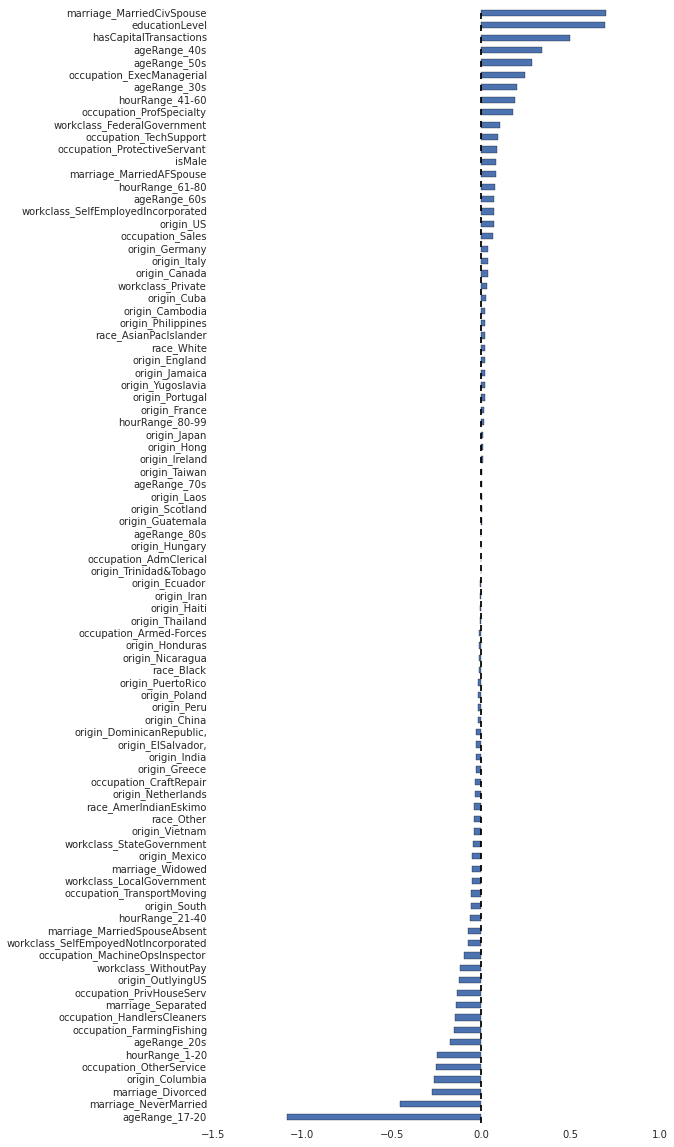

In [36]:
# now let's make a pandas Series with the names and values, and plot them
%matplotlib inline

weights = pd.Series(LRTask1.coef_[0],index=df1.columns)
weights = weights.order(ascending=True)
weights.plot(kind='barh',figsize=(8,20))

As we can see from the bar chart above, the attributes that are most related to **making more than 50K a year** are:
* The Education Level
* Being Married to a civilian
* Having capital transactions

These make sense, especially capital transactions because if people that have enough money to be investing in stock, real state, etc, probably have a salary higher than 50K.
Being married to a civilian (the other choice was married to someone from the air force) also shows that a typical married life might make it easy to grow professionally and increase your salary.
Lastly, the education level, is directly related, simply because the higher the education level is, the more people will pay for your work.

On the opposite end of the bar chart, the inversely related attributes are:
* Being 17 to 20 years old
* Never being Married
* Having other service as occupation

The age is fairly obvious, because someone under 20 years old is unlikely to make more than 50K a year.
The interesting one is never being married, which seems to inversely affect your chances of making a high salary.
Finally, for the occupation as "other service", it probably refers to the service industry or jobs as such.

#### Classification Task 2
Predict if a person makes capital trades, based on their age, race, sex, etc. (all of the attributes)

In [37]:
# sort these attributes and spit them out
zip_vars = zip(LRTask2.coef_.T,df2.columns)
zip_vars.sort(key = lambda t: np.abs(t[0]))
for coef, name in reversed(zip_vars):
    print name, 'has importance of', coef[0]

salaryOver50K has importance of 0.617745397424
educationLevel has importance of 0.140393497192
origin_Thailand has importance of -0.134919856163
origin_OutlyingUS has importance of -0.119899001279
occupation_OtherService has importance of -0.116296007528
origin_Scotland has importance of -0.115433155634
ageRange_20s has importance of -0.109063958557
ageRange_60s has importance of 0.108867096357
ageRange_70s has importance of 0.0917350536655
ageRange_17-20 has importance of -0.0683289581235
origin_Netherlands has importance of 0.0677159753433
origin_Vietnam has importance of 0.0599554479259
origin_Jamaica has importance of -0.05009276041
ageRange_50s has importance of 0.041972412069
race_AsianPacIslander has importance of -0.0417811817768
ageRange_80s has importance of 0.0415189135209
occupation_ExecManagerial has importance of 0.0386921759318
occupation_ProtectiveServant has importance of -0.0382584743108
ageRange_40s has importance of 0.0380388036471
occupation_ProfSpecialty has impor

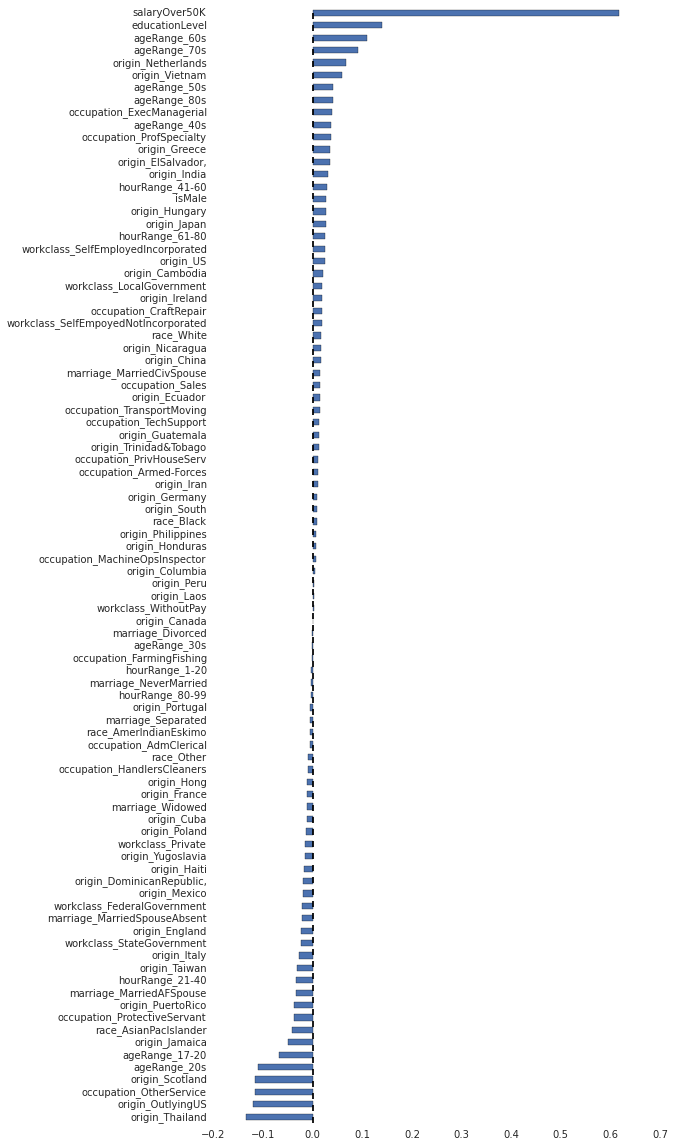

In [38]:
# now let's make a pandas Series with the names and values, and plot them
%matplotlib inline

weights = pd.Series(LRTask2.coef_[0],index=df2.columns)
weights = weights.order(ascending=True)
weights.plot(kind='barh',figsize=(8,20))

As we can see from the bar chart above, the attributes that are most related to **having capital trades are**:
* Having a salary over 50K
* Being in your 60s
* Education level

Similarly to our previous classification task, a salary larger than 50K is closely related to making investments and/or capital transactions. This is probably because of the sparse income that can be risked in an easier way.
Apparently people on their 60s tend to make a lot of capital trades, and also the education level is directly related.

On the opposite end of the bar chart, the inversely related attributes are:
* Originating from Scotland, Thailand or the Outlying US
* Having other service as occupation
* Being 17 to 20 years old

The age is fairly obvious, because someone under 20 years old is unlikely to make capital trades.
The other two are more ambiguous predictions.

#### Classification Task 3
Predict if a person is male, based on their age, race, sex, etc. (all of the attributes)

In [39]:
# sort these attributes and spit them out
zip_vars = zip(LRTask3.coef_.T,df3.columns)
zip_vars.sort(key = lambda t: np.abs(t[0]))
for coef, name in reversed(zip_vars):
    print name, 'has importance of', coef[0]

occupation_CraftRepair has importance of 0.656503780505
marriage_MarriedCivSpouse has importance of 0.615241699404
occupation_AdmClerical has importance of -0.493291352999
occupation_TransportMoving has importance of 0.424378919661
marriage_Widowed has importance of -0.419294899798
marriage_Divorced has importance of -0.411562933995
occupation_HandlersCleaners has importance of 0.31064740276
occupation_ProfSpecialty has importance of -0.28342548473
occupation_FarmingFishing has importance of 0.282455555834
occupation_PrivHouseServ has importance of -0.238577742899
marriage_Separated has importance of -0.198684332287
occupation_ExecManagerial has importance of -0.195900234279
hourRange_41-60 has importance of 0.19550987755
occupation_OtherService has importance of -0.194608209601
hourRange_1-20 has importance of -0.173287649531
occupation_Sales has importance of -0.165006408631
occupation_ProtectiveServant has importance of 0.164180630378
hourRange_21-40 has importance of -0.12686889281

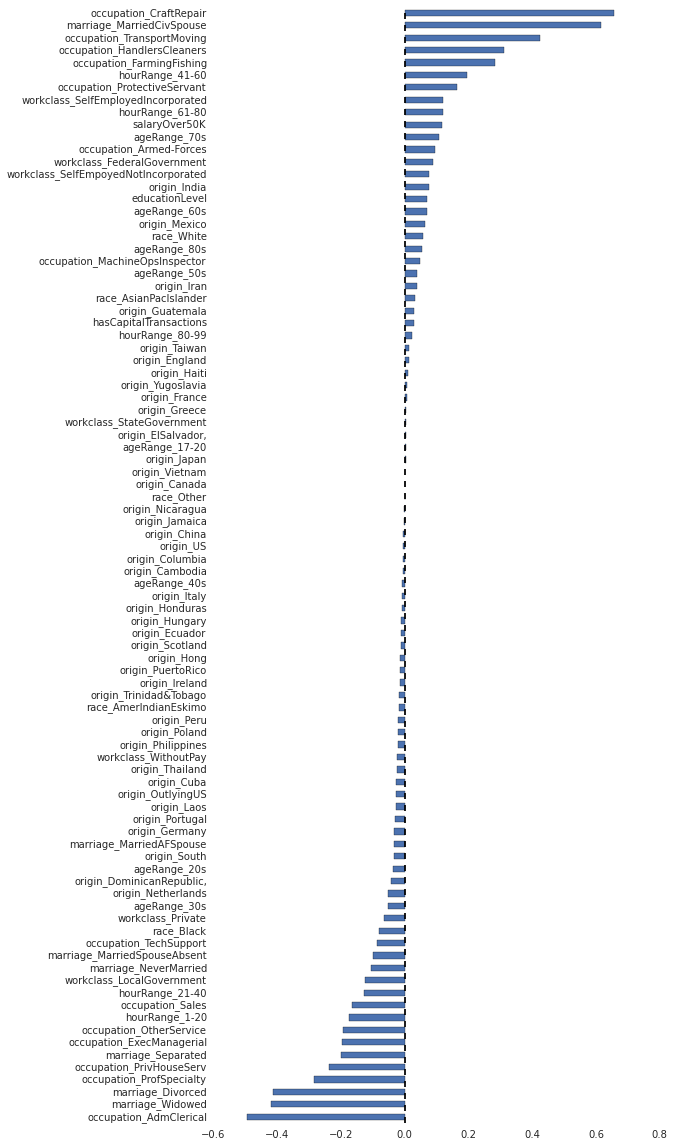

In [40]:
# now let's make a pandas Series with the names and values, and plot them
%matplotlib inline

weights = pd.Series(LRTask3.coef_[0],index=df3.columns)
weights = weights.order(ascending=True)
weights.plot(kind='barh',figsize=(8,20))

As we can see from the bar chart above, the attributes that are most related to **being a male** are:
* Occupation in craft/repairs, transport/moving, handlers/cleaners and fishing/farming
* Being married to a civilian
* Working from 41-60 hours a week

We can see that those occupations are mostly associated with males, but being married and working 41-60 hours a week are hard to see the relationship.

On the opposite end of the bar chart, the inversely related attributes are:
* Being widowed or divorced or separated
* Occupation in Adm Clerical, Prof Specialty, Private Hous Service
* Working from 1-20 hours

Considering that this census is from 1994, these predictions seem to be based on the traditional household, where woman stayed at home or wokred part time.
It is interesting to see how being widowed, divorced or separated is mostly associated with women in this data set.

---
### 4. SVM Support Vectors (15 points)
**Look at the chosen support vectors for the classification task. Do these provide any insight into the data? Explain.**

#### Classification Task 1
Predict if a person makes more than 50, 000 dollars a year, based on their age, race, sex, etc. (all of the attributes)

In [41]:
# look at the support vectors
print svm_clf1.support_vectors_.shape
print svm_clf1.support_.shape
print svm_clf1.n_support_ 

(8994, 90)
(8994,)
[4529 4465]


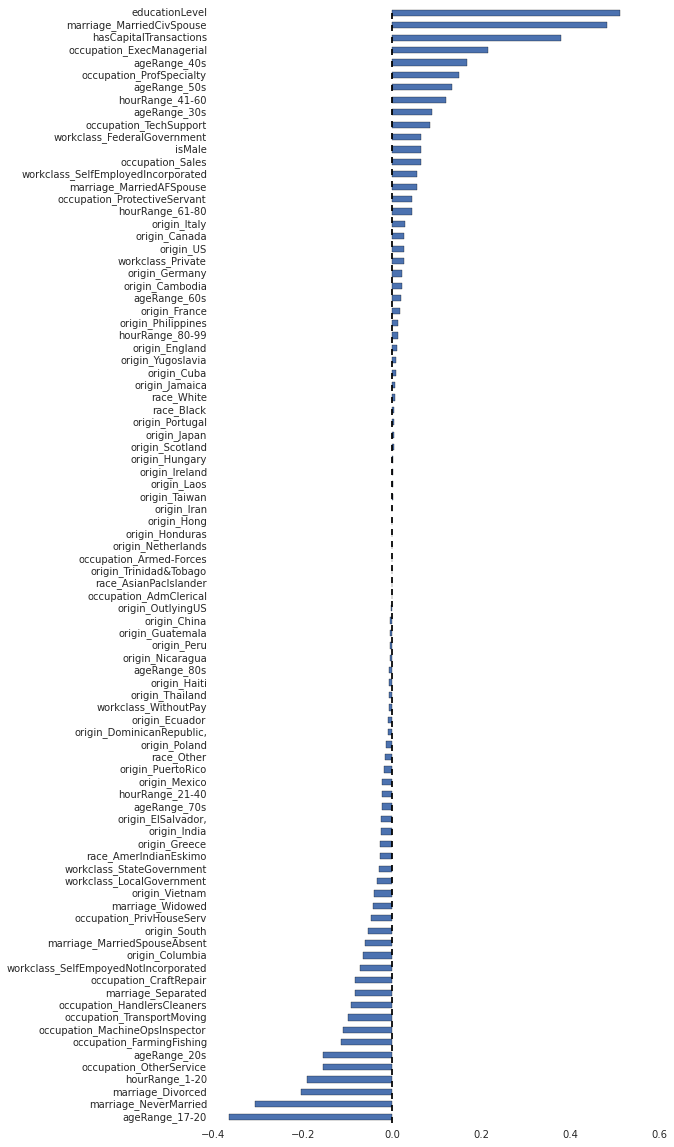

In [42]:
# These are the support vectors of our classification task 1
weights = pd.Series(svm_clf1.coef_[0],index=df1.columns)
weights = weights.order(ascending=True)
weights.plot(kind='barh',figsize=(8,20))

The chart above indicates a variety of attributes that are either positively or negatively correlated with whether or not an individual has a salaray of **more than $50K**:
* Education level (highly positive correlation)
* Being married to a civilian spouse (highly positive correlation)
* Making capital transactions (either making gains or losses, both positive correlations)
* Having never been married before or remaining single after a divorce (both negative correlations)
* Being between the age of 17-20 (negative correlation)

These results are very understandable. It would be expected that someone who has a high education level, is married to a civilian spouse, and/or makes capital transactions would make a yearly salary of $50K or greater.

It is also not surprising that being young (17-20) or being single (either never married or single after a divorce) is correlated with having a salary of less than $50k per year.

#### Classification Task 2
Predict if a person makes capital trades, based on their age, race, sex, etc. (all of the attributes)

In [43]:
# look at the support vectors
print svm_clf2.support_vectors_.shape
print svm_clf2.support_.shape
print svm_clf2.n_support_ 

(9437, 90)
(9437,)
[6235 3202]


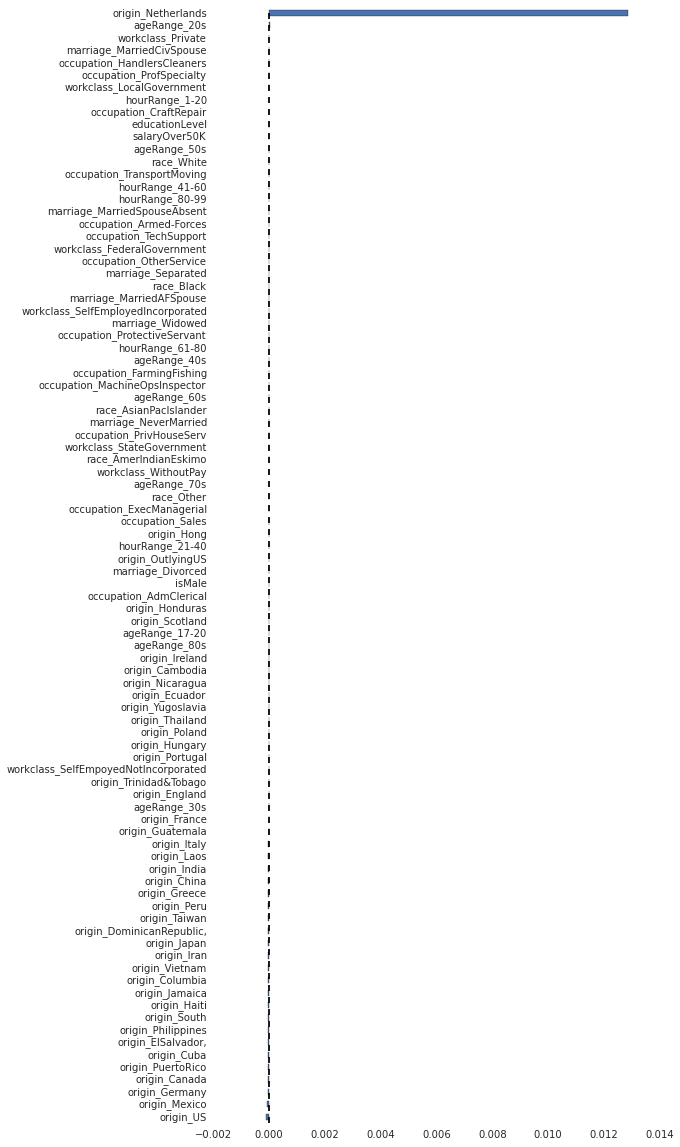

In [44]:
# These are the support vectors of our classification task 2
weights = pd.Series(svm_clf2.coef_[0],index=df2.columns)
weights = weights.order(ascending=True)
weights.plot(kind='barh',figsize=(8,20))

The chart above indicates that there are several attributes which are highly correlated with **making capital transactions** are:
* Occupation as administration or clerical positions (negative correlation)
* Race of Asian/Pacific Islander (negative correlation)
* Hour Range (Either between 41-60 [negative correlation] or between 1 and 20 [positive correlation])
* US Origin (positive correlation)

These results are somewhat surprising, however, the origin and racial considerations may be rooted in cultural norms and life outlooks. The correlation between hours worked (1-20) and making capital transactions is somewhat surprising as many would imagine this correlation would be negative, however, it is positive in the context of our training set. Gathering additional information or additional instances of data may alter this attributes affect on the target.

#### Classification Task 3
Predict if a person is male, based on their age, race, sex, etc. (all of the attributes)

In [45]:
# look at the support vectors
print svm_clf3.support_vectors_.shape
print svm_clf3.support_.shape
print svm_clf3.n_support_ 

(11856, 90)
(11856,)
[5691 6165]


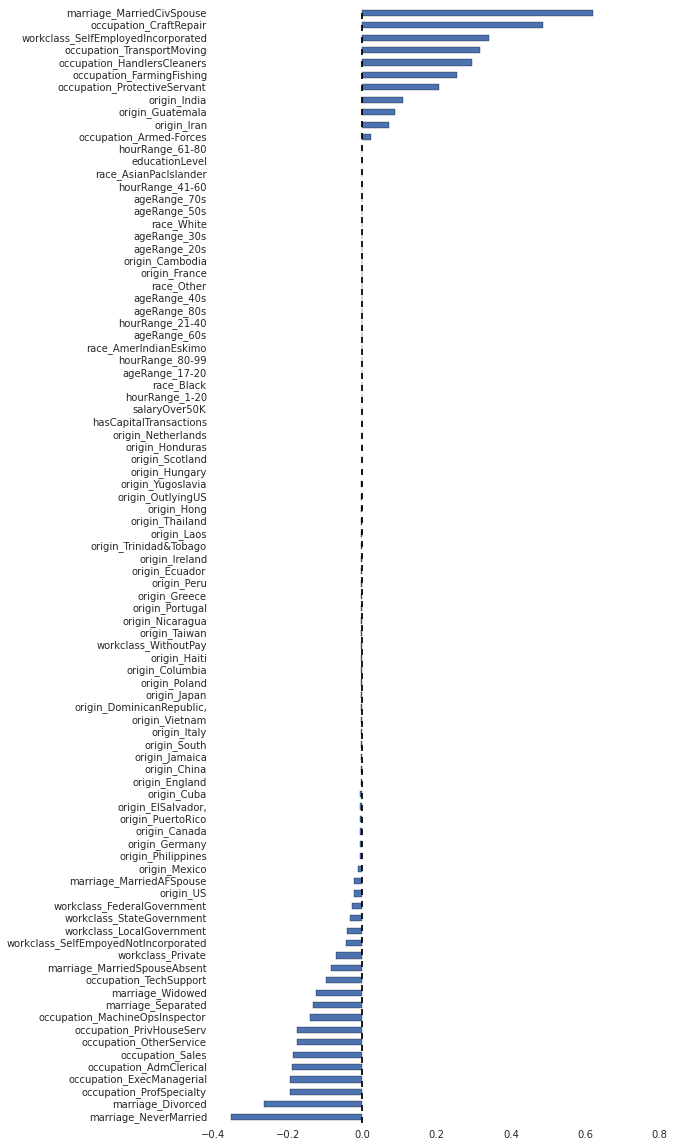

In [46]:
# These are the support vectors of our classification task 3
weights = pd.Series(svm_clf3.coef_[0],index=df3.columns)
weights = weights.order(ascending=True)
weights.plot(kind='barh',figsize=(8,20))

Finally, this chart indicates that there are several attributes present in the model for classification task 3 which are highly correlated with whether or not an individual is **male**:
* Being married to a civilian spouse (highly positive correlation)
* Having an occupation as a Craftsman or Repairman (highly positive correlation)
* Being self employed (positive correlation)
* Having never been married before or remaining single after a divorce (both negative correlations)

These results fall in line with expectations. The occupations discussed above would more than likely be dominantly male, being self employed would seem to be correlated with being male in the US, and finally, it is not surprising that males are also more likely to never become married or to remain single after becoming divorced.

---
### 4. Model Performace (5 points)
**Assess how well each model performs (use training/test data as appropriate)**

In [47]:
# For each model, we used the same training/testing sizes:
# TRAINING: 80% of the data set
# TESTING: 20% of the data set

In [48]:
print "MODEL 1 PERFORMANCE:"
print("Logistic Regression: %.2f" % (modelOneReg*100))+"%"
print("SVM: %.2f" % (modelOneSVM*100))+"%"+"\n"

MODEL 1 PERFORMANCE:
Logistic Regression: 84.39%
SVM: 84.10%



In [49]:
print "MODEL 2 PERFORMANCE:"
print("Logistic Regression: %.2f" % (modelTwoReg*100))+"%"
print("SVM: %.2f" % (modelTwoSVM*100))+"%"+"\n"

MODEL 2 PERFORMANCE:
Logistic Regression: 87.39%
SVM: 87.35%



In [50]:
print "MODEL 3 PERFORMANCE:"
print("Logistic Regression: %.2f" % (modelThreeReg*100))+"%"
print("SVM: %.2f" % (modelThreeSVM*100))+"%"+"\n"

MODEL 3 PERFORMANCE:
Logistic Regression: 79.93%
SVM: 77.87%



As we can see from these numbers, both models perform excedingly well.
We highly prefer logistic regression because it runs extremely fast and produces very accurate predictions.

Evaluation and Deployment
---

---
### 1. Model Evaluation (5 points)
**How useful is your model for interested parties (i.e., the companies or organizations that might want to use it for prediction)? How would you measure the model's value if it was used? How would your deploy your model for interested parites? What other data should be collected? How often would the model need to be updated, etc. ?**

Out of our three classification models, the most likely to be adopted by businesses would be the model that predicts whether an individual makes a salary of $50k or more. A person’s trading activity would be important information to certain businesses, especially in terms of identifying potential tax audits or for identifying discrepancies in reported earnings, however, it is unlikely that it would be widely adopted. Furthermore, the model that predicts whether an individual is male might be helpful in the presence of certain demographic information, however, it is highly likely that other data attributes would be a much stronger indicator of whether an individual is male.

The model predicting salary of an individual would be incredibly useful for businesses. This model could be used (assuming the business had access to demographic information) to help predict wether or not a specific individual would be interested in purchasing a luxury product or service, or at minimum, whether the person could actually afford this product or service. Given the high rate of accuracy of our model, it would be very beneficial to certain businesses.

In order to measure the model’s value, we could evaluate the conversion rate from targeted sales efforts. If the model identifies a certain portion of the population that is likely to make over $50k, targeted advertisements could be made to those individuals. The rate of which those ads lead to sales could be used as an indicator for the overall value of the model and the use of the model.

Deploying the model would require a decent amount of data regarding the individual(s) being targeted. Once this data was obtained, it would be very simple to identify the which members of the population are estimated to make a salary of $50k or more and advertisements could then be made to these individuals. After advertisements have reached their targets, data should be recorded as to whether or not the individual purchased the product or service. This data could eventually be used to form a new model which further predicts whether an individual would be interested in a specific product or service as opposed to a category of products or services.

Lastly, the model would not need to be updated, however, additional information may help further refine the model and improve accuracy. In addition, the information mentioned above could be used to form a new model which may be even more beneficial to specific businesses.

Exceptional Work (10 points)
---

---
### 1. Model Evaluation (5 points)
**You have free reign to provide additional modeling. One idea: fuse the outputs of the two classifiers to create a new classifier or use grid searching to estimate parameters of the models.**

We did 3 classification tasks, instead of only 2, which counts for additional modeling and exceptional work. :D